# \
In previous notebooks our analyses have been limited to just simple linear regression where we have one explanatory variable *x* and one dependent variable *y*. Now in this analysis we are going to take this a bit further to include more than one right-hand variable and see how the results differ.

In [1]:
from typing import Union
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from typing import Union
sys.path.append('..')
from packages import utils
from stargazer.stargazer import Stargazer

In a previous analysis we regressed the natural log of review counts conditional on `transactioncounts`. We'll take this analysis further but prior to that we'll do a brief recap.

In [2]:
cg_df = pd.read_parquet('cg_est', engine='pyarrow')
bh_df: pd.DataFrame = pd.read_parquet('bus_holdings.snappy.parquet', engine='pyarrow')
bus_cats_df = pd.read_parquet('bus_cats', engine='pyarrow')
bt_df = pd.read_parquet('business_transactions.snappy.parquet', engine='pyarrow')

Here we came to the conclusion that it would be best to transform the `ReviewCounts` variable.

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


[Text(0.5, 1.0, 'After Transformation'), Text(0, 0.5, 'ln_review_count (ln)')]

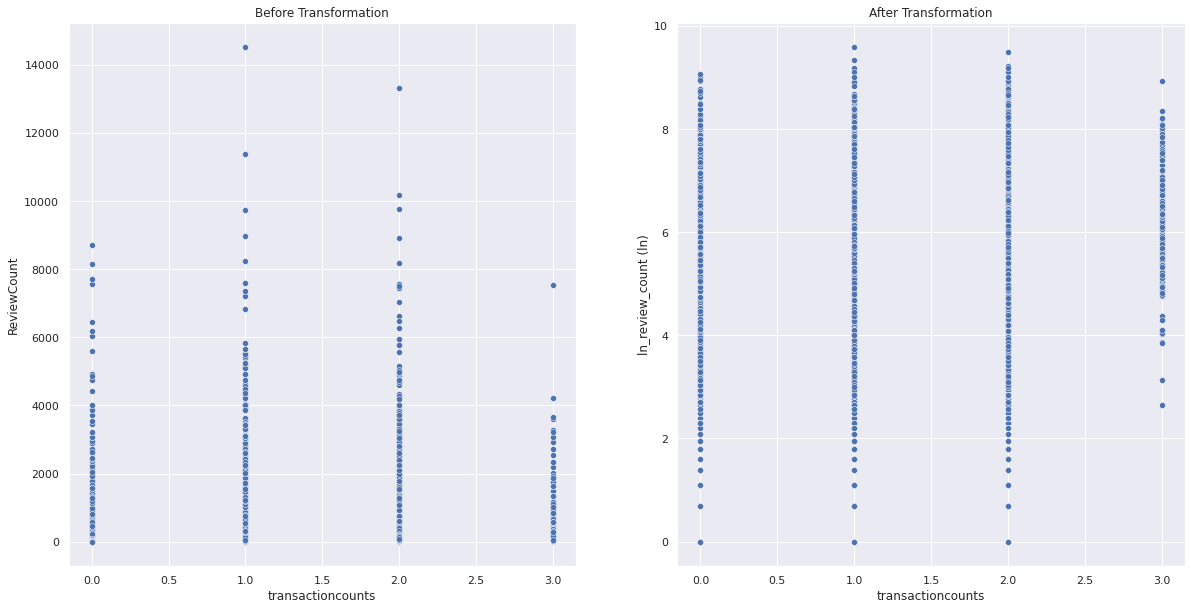

In [3]:
most_recent_bh_tran_df = utils.most_recent_businesses_df(df1 = bh_df, df2= bt_df, on= 'BusinessKey', remove_na=True)
most_recent_bh_df_sin_cero = most_recent_bh_tran_df[most_recent_bh_tran_df['ReviewCount'] > 0 ]
most_recent_bh_df_sin_cero.loc[:, 'ln_review_count'] = np.log(most_recent_bh_df_sin_cero['ReviewCount'])
sns.set_theme()
fig, axes = plt.subplots(1,2, figsize=(20, 10))

sns.scatterplot(x=most_recent_bh_df_sin_cero['transactioncounts'], y=most_recent_bh_df_sin_cero['ReviewCount'], x_jitter=.30, ax=axes[0])

sns.scatterplot(x=most_recent_bh_df_sin_cero['transactioncounts'], y=most_recent_bh_df_sin_cero['ln_review_count'], x_jitter=.30,ax=axes[1] )
axes[0].set(title='Before Transformation')
axes[1].set(title='After Transformation', ylabel=f'{axes[1].get_ylabel()} (ln)')

Then having taken a look at the R-squared of this regression we got rather satisfactory results for just one variable.

In [4]:
X_tc = most_recent_bh_df_sin_cero['transactioncounts']
X_tc_with_constant = sm.add_constant(X_tc)

y = most_recent_bh_df_sin_cero['ln_review_count']

univariate_lin_model = sm.OLS(y, X_tc_with_constant)
results = univariate_lin_model.fit(cov_type='HC1')
results.summary()

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_review_count   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                 2.111e+04
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        08:06:53   Log-Likelihood:            -1.1824e+05
No. Observations:               63307   AIC:                         2.365e+05
Df Residuals:                   63305   BIC:                         2.365e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.6400      0.008    348.865      0.000       2.625       2.655
transactioncounts     1.2511      0.009    145.284      0.000       1.234       1.268
==============================================================================
Omnibus:                      379.506   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              338.003
Skew:                           0.134   Prob(JB):                     4.02e-74
Kurtosis:                       2.763   Cond. No.                         1.91
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Now what if we want better results in our regression? Assuming we our goal is beyond mere association of variables at this point and want to go through prediction then we would ideally want to use more variable to explain more of the changes we are saying in our dependent variable.
> Note: We are making a distinction between "explain more changes" and causality. Also we will continue to postpone the idea of worksets and holdout sets.

We have yet to use qualitative variables so this time we can create one from the `transactioncounts`. However as one would expect this variable would be highly related to `transactioncounts` which will create some problems with our SEs later down the line. We can this this with the following example.

In [5]:
most_recent_bh_df_sin_cero.loc[:,'delivery'] = np.where(most_recent_bh_df_sin_cero.loc[:,'transactions_list'].str.contains('delivery'), 1 , 0)

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Here the `delivery` binary variable is highly correlated to `transactioncounts` and we ideally wouldn't want these both in the regression together.

In [6]:
most_recent_bh_df_sin_cero.corr()['delivery']

BusinessKey              -0.038950
BusinessRating            0.086307
ReviewCount               0.257154
previous_review_cnt       0.257140
abs_review_diff           0.005271
total_review_cnt_delta    0.009201
transactioncounts         0.897249
ln_review_count           0.511699
delivery                  1.000000
Name: delivery, dtype: float64

Instead we'll make a different one to indicate if a business serves one of the top 5 business categories or not.

In [7]:
top_5_cat_list = bus_cats_df['BusinessCategoryName'].value_counts(normalize=True).head(5).index.tolist()
top_5_cat_list



['American (Traditional)', 'Pizza', 'Burgers', 'Sandwiches', 'Mexican']

In [29]:
from google.oauth2 import service_account
from google.cloud import bigquery

In [30]:
KEY_PATH = "/mnt/c/Users/Ron/git-repos/yelp-data/gourmanddwh-f75384f95e86.json"
CREDS = service_account.Credentials.from_service_account_file(KEY_PATH)
client = bigquery.Client(credentials=CREDS, project=CREDS.project_id)

In [31]:
cat_file = open('sql_scripts/business_category_location_revised.sql')
cat_query = cat_file.read()

cat_df : pd.DataFrame = (
    client.query(cat_query)
    .result()
    .to_dataframe()
)

In [34]:
cat_df.to_parquet('cat_df.snappy.parquet', 'pyarrow','snappy', partition_cols=['StateName'])

In [8]:
cat_df = pd.read_parquet('cat_df.snappy.parquet', engine='pyarrow')
cat_df

,BusinessKey,BusinessName,ChainName,PaymentLevelName,Longitude,Latitude,CityName,CountyName,CountryName,business_cat_list,cat_counts,StateName
0,1,the-pie-source-new-mexico,The Pie Source,Unknown,-108.128867000,34.298479000,New Mexico,Catron County,GB,"Coffee & Tea, Desserts, Bakeries",3.0,ABE
1,50,autauga-creek-craft-house-prattville,Autauga Creek Craft House,Low,-86.474250000,32.460080000,Prattville,Autauga County,US,Bars,1.0,Alabama
2,80,york-truck-stop-york,York Truck Stop,Very Low,-88.298618000,32.518070000,York,Kemper County,US,"Delis, Gas Stations",2.0,Alabama
3,119,the-seafood-house-mobile,The Seafood House,Low,-88.139530000,30.652850000,Mobile,Mobile County,US,Seafood,1.0,Alabama
4,152,hooligans-tuscaloosa-3,Hooligans,Very Low,-87.534060000,33.231182000,Tuscaloosa,Tuscaloosa County,US,"Mediterranean, Burgers, American (Traditional)",3.0,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...
63312,63256,sweet-lous-bakery-and-cafe-torrington,Sweet Lou's Bakery And Cafe,Low,-104.171481000,42.064063000,Torrington,Goshen County,US,"Cafes, Bakeries",2.0,Wyoming
63313,63277,dairyland-thermopolis,Dairyland,Very Low,-108.210450000,43.650900000,Thermopolis,Hot Springs County,US,"Burgers, Hot Dogs, Ice Cream & Frozen Yogurt",3.0,Wyoming
63314,63290,black-bear-cafe-thermopolis,Black Bear Cafe,Low,-108.210066000,43.646430000,Thermopolis,Hot Springs County,US,"Breakfast & Brunch, American (Traditional), Cafes",3.0,Wyoming
63315,63316,the-crown-inn-london,The Crown Inn,Unknown,0.073200000,51.410740000,London,Laurel County,GB,Pubs,1.0,XGL


In [9]:
most_recent_bh_df_sin_cero_cat_df = pd.merge(left=most_recent_bh_df_sin_cero, right=cat_df, left_on='BusinessKey', right_on='BusinessKey', how='inner')
most_recent_bh_df_sin_cero_cat_df.shape

(63307, 28)

In [10]:
most_recent_bh_df_sin_cero_cat_df['business_cat_list'] = most_recent_bh_df_sin_cero_cat_df['business_cat_list'].str.split(', ')
most_recent_bh_df_sin_cero_cat_df['business_cat_list']

0                                          [Seafood]
1                                            [Cafes]
2                                          [Mexican]
3        [Coffee Roasteries, Coffee & Tea, Bakeries]
4                             [Donuts, Coffee & Tea]
                            ...                     
63302          [Sports Bars, American (Traditional)]
63303                                        [Pizza]
63304                                      [Italian]
63305                           [Mexican, Caribbean]
63306                                      [Spanish]
Name: business_cat_list, Length: 63307, dtype: object

In [11]:
def row_lvl_comparison(row, target_col:str,  target_list: list,  col_name_edit: Union[str, None] = None):
    the_dict = {}
    the_dict[f'{col_name_edit}_match'] =  0 
    the_dict[f'{col_name_edit}_matches'] =  0
    for item in row[target_col]:
        if item in target_list:
            the_dict[f'{col_name_edit}_match'] = 1
            the_dict[f'{col_name_edit}_matches'] += 1
        else:
            continue
    
    return pd.Series(the_dict)

In [12]:
cats_series = most_recent_bh_df_sin_cero_cat_df.apply(row_lvl_comparison,target_col='business_cat_list',target_list=top_5_cat_list,col_name_edit='top_5_cat',axis=1)


In [13]:
most_recent_bh_df_sin_cero_cat_df = pd.concat([most_recent_bh_df_sin_cero_cat_df, cats_series], axis=1)
most_recent_bh_df_sin_cero_cat_df

,BusinessKey,BusinessName_x,ChainName_x,BusinessRating,ReviewCount,previous_review_cnt,previous_rating,abs_review_diff,abs_rating_diff,total_review_cnt_delta,...,Longitude,Latitude,CityName,CountyName,CountryName,business_cat_list,cat_counts,StateName,top_5_cat_match,top_5_cat_matches
0,53160,deutschlander-buffalo-gap-2,Deutschlander,4.0,37,37.0,4.000000000,0.0,0E-9,0.0,...,-99.826970000,32.274950000,Buffalo Gap,Taylor County,US,[Seafood],1.0,Texas,0,0
1,9203,sips-and-such-café-alma,Sips and Such Café,5.0,4,4.0,5.000000000,0.0,0E-9,0.0,...,-82.463774000,31.530589000,Alma,Bacon County,US,[Cafes],1.0,Georgia,0,0
2,27671,la-fuente-mexican-restaurant-meridian,La Fuente Mexican Restaurant,4.0,41,41.0,4.000000000,0.0,0E-9,0.0,...,-88.669075000,32.360134000,Meridian,Lauderdale County,US,[Mexican],1.0,Mississippi,1,1
3,48461,red-oak-roasters-rickman-3,Red Oak Roasters,5.0,6,6.0,5.000000000,0.0,0E-9,1.0,...,-85.371622000,36.261856000,Rickman,Overton County,US,"[Coffee Roasteries, Coffee & Tea, Bakeries]",3.0,Tennessee,0,0
4,28381,arcadia-valley-roasting-company-ironton,Arcadia Valley Roasting Company,4.5,7,7.0,4.500000000,0.0,0E-9,0.0,...,-90.627341000,37.598639000,Ironton,Reynolds County,US,"[Donuts, Coffee & Tea]",2.0,Missouri,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63302,23543,zzs-sports-bar-and-grill-adrian,ZZ's Sports Bar & Grill,3.5,10,10.0,3.500000000,0.0,0E-9,-60.0,...,-84.042870000,41.897612000,Adrian,Lenawee County,US,"[Sports Bars, American (Traditional)]",2.0,Michigan,1,1
63303,5467,zzzz-s-pizzzza-burlington,ZZZZ’s PIzzzza,5.0,1,1.0,5.000000000,0.0,0E-9,-1.0,...,-102.267640000,39.304240000,Burlington,Cheyenne County,US,[Pizza],1.0,Colorado,1,1
63304,13045,àlavita-boise-2,ÀLAVITA,4.0,308,309.0,4.000000000,-1.0,0E-9,55.0,...,-116.203039000,43.616351000,Boise,Elmore County,US,[Italian],1.0,Idaho,0,0
63305,44974,ándale-caguas-2,Ándale,5.0,3,3.0,5.000000000,0.0,0E-9,0.0,...,-66.038267000,18.257744000,Caguas,Aguas Buenas Municipio,US,"[Mexican, Caribbean]",2.0,Puerto Rico,1,1


Now we can see how the review counts are correlated with our new variable.

In [14]:
most_recent_bh_df_sin_cero_cat_df['top_5_cat_match'].value_counts()

0    33608
1    29699
Name: top_5_cat_match, dtype: int64

<Figure size 1080x720 with 0 Axes>

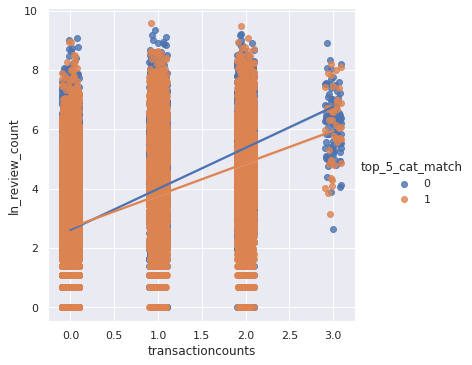

In [15]:
sns.set_theme()
plt.figure(figsize=(15, 10))
sns.lmplot(x="transactioncounts", y="ln_review_count", hue="top_5_cat_match", data=most_recent_bh_df_sin_cero_cat_df, x_jitter=.10)


Based on this regression plot, it seems that those businesses who do not participate in the top 5 most popular business categories tend to have higher review counts than those that do. \
We can estimate this formally now.

In [16]:
X_tc_cat_bin = most_recent_bh_df_sin_cero_cat_df[['transactioncounts', 'top_5_cat_match']]
X_tc_cat_bin_with_constant = sm.add_constant(X_tc_cat_bin)

y = most_recent_bh_df_sin_cero_cat_df['ln_review_count']

multivariate_lin_model = sm.OLS(y, X_tc_cat_bin_with_constant)
mlm_results = multivariate_lin_model.fit(cov_type='HC1')
mlm_results.summary()

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_review_count   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                 1.074e+04
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        08:07:30   Log-Likelihood:            -1.1823e+05
No. Observations:               63307   AIC:                         2.365e+05
Df Residuals:                   63304   BIC:                         2.365e+05
Df Model:                           2                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.6695      0.010    264.366      0.000       2.650       2.689
transactioncounts     1.2501      0.009    145.074      0.000       1.233       1.267
top_5_cat_match      -0.0619      0.012     -4.975      0.000      -0.086      -0.038
==============================================================================
Omnibus:                      372.630   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.526
Skew:                           0.130   Prob(JB):                     2.78e-72
Kurtosis:                       2.761   Cond. No.                         2.92
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Based on these results our new variable hasn't really helped at all. 

In [20]:
X_tc_with_constant = sm.add_constant(most_recent_bh_df_sin_cero_cat_df['transactioncounts'])
simple_lin_reg_tc_cat_bin = sm.OLS(most_recent_bh_df_sin_cero_cat_df['top_5_cat_match'], X_tc_with_constant)
slrtcb_results = simple_lin_reg_tc_cat_bin.fit(cov_type='HC1')

Stargazer([results, mlm_results, slrtcb_results])

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


With the regression models displayed as such we can also caluculate our omitted variable bias in 2 ways. \
The first method is simply to subtract the coefficient on `transactioncounts` in the multivariate linear regression from the first univariate regression with transaction counts. That would be $$ 1.251 - 1.250 = .001$$ 
The second method is to do a regression with the newly added explanatory variable in this case as the dependent variable and `transactioncounts` as the explanatory variable. Then we can take the product of `transactioncounts` and `top_5_cat_match` in our multivariate regression yielding $$ -0.062 * -0.016 = 0.000992 $$ but rounded we would get 0.001

As already established this new variable didn't do much for our regression so there isn't much of a omitted variable bias. So we are going to add in PaymentLevelName as a qualitative variable instead and see if that helps at all. 

In [28]:
most_recent_bh_df_sin_cero_cat_df.PaymentLevelName.value_counts()

Low          23397
Very Low     20126
Unknown      18114
High          1488
Very High      182
Name: PaymentLevelName, dtype: int64

When making the dummy variable we will leave 'Low' as the reference category since that contains the most observations in effect reducing the resulting SE's. Also in a previous analysis we did we noticed that this category had better ratings when compared to some others.

In [32]:
payment_lvl_dummies = pd.get_dummies(most_recent_bh_df_sin_cero_cat_df.PaymentLevelName).drop('Low', axis=1)
payment_lvl_dummies

,High,Unknown,Very High,Very Low
0,0,0,0,0
1,0,1,0,0
2,0,0,0,1
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
63302,0,0,0,0
63303,0,1,0,0
63304,0,0,0,0
63305,0,1,0,0


In [33]:
most_recent_bh_df_sin_cero_cat_dummies_df = pd.merge(most_recent_bh_df_sin_cero_cat_df, payment_lvl_dummies, how='inner', left_index=True, right_index=True)
most_recent_bh_df_sin_cero_cat_dummies_df

,BusinessKey,BusinessName_x,ChainName_x,BusinessRating,ReviewCount,previous_review_cnt,previous_rating,abs_review_diff,abs_rating_diff,total_review_cnt_delta,...,CountryName,business_cat_list,cat_counts,StateName,top_5_cat_match,top_5_cat_matches,High,Unknown,Very High,Very Low
0,53160,deutschlander-buffalo-gap-2,Deutschlander,4.0,37,37.0,4.000000000,0.0,0E-9,0.0,...,US,[Seafood],1.0,Texas,0,0,0,0,0,0
1,9203,sips-and-such-café-alma,Sips and Such Café,5.0,4,4.0,5.000000000,0.0,0E-9,0.0,...,US,[Cafes],1.0,Georgia,0,0,0,1,0,0
2,27671,la-fuente-mexican-restaurant-meridian,La Fuente Mexican Restaurant,4.0,41,41.0,4.000000000,0.0,0E-9,0.0,...,US,[Mexican],1.0,Mississippi,1,1,0,0,0,1
3,48461,red-oak-roasters-rickman-3,Red Oak Roasters,5.0,6,6.0,5.000000000,0.0,0E-9,1.0,...,US,"[Coffee Roasteries, Coffee & Tea, Bakeries]",3.0,Tennessee,0,0,0,1,0,0
4,28381,arcadia-valley-roasting-company-ironton,Arcadia Valley Roasting Company,4.5,7,7.0,4.500000000,0.0,0E-9,0.0,...,US,"[Donuts, Coffee & Tea]",2.0,Missouri,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63302,23543,zzs-sports-bar-and-grill-adrian,ZZ's Sports Bar & Grill,3.5,10,10.0,3.500000000,0.0,0E-9,-60.0,...,US,"[Sports Bars, American (Traditional)]",2.0,Michigan,1,1,0,0,0,0
63303,5467,zzzz-s-pizzzza-burlington,ZZZZ’s PIzzzza,5.0,1,1.0,5.000000000,0.0,0E-9,-1.0,...,US,[Pizza],1.0,Colorado,1,1,0,1,0,0
63304,13045,àlavita-boise-2,ÀLAVITA,4.0,308,309.0,4.000000000,-1.0,0E-9,55.0,...,US,[Italian],1.0,Idaho,0,0,0,0,0,0
63305,44974,ándale-caguas-2,Ándale,5.0,3,3.0,5.000000000,0.0,0E-9,0.0,...,US,"[Mexican, Caribbean]",2.0,Puerto Rico,1,1,0,1,0,0


First we're going to take regressions separately for each different payment level and then take a pooled regression to see the differences.

In [64]:
payment_lvls = most_recent_bh_df_sin_cero_cat_dummies_df.PaymentLevelName.unique().tolist()
reg_dict = {}
reg_list_tuples: list = []
for payment_lvl in payment_lvls:
    cut_df = most_recent_bh_df_sin_cero_cat_dummies_df.loc[most_recent_bh_df_sin_cero_cat_dummies_df.PaymentLevelName == payment_lvl, :]
    y_cut = cut_df['ln_review_count']
    X_cut_with_constant = sm.add_constant(cut_df['transactioncounts'])
    cut_model = sm.OLS(y_cut, X_cut_with_constant)
    cut_model_results = cut_model.fit(cov_type='HC1')

    reg_dict[payment_lvl] = cut_model_results
    reg_tuple = (payment_lvl, cut_model_results,)
    reg_list_tuples.append(reg_tuple)

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [65]:
most_recent_bh_df_sin_cero_cat_dummies_df['tc_by_Unknown'] = most_recent_bh_df_sin_cero_cat_dummies_df['transactioncounts'] * most_recent_bh_df_sin_cero_cat_dummies_df['Unknown']


In [66]:
X_tc_dummies_inter = most_recent_bh_df_sin_cero_cat_dummies_df[['transactioncounts', 'High', 'Unknown', 'Very High', 'Very Low', 'tc_by_Unknown']]
X_tc_dummies_inter_with_constant = sm.add_constant(X_tc_dummies_inter)
multivariate_inter_model = sm.OLS(y, X_tc_dummies_inter_with_constant)
multivariate_inter_model_results = multivariate_inter_model.fit(cov_type='HC1')

In [67]:
multivariate_inter_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_review_count   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     9489.
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:05:19   Log-Likelihood:            -1.0709e+05
No. Observations:               63307   AIC:                         2.142e+05
Df Residuals:                   63300   BIC:                         2.142e+05
Df Model:                           6                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.7998      0.011    350.032      0.000       3.779       3.821
transactioncounts     0.8346      0.009     97.777      0.000       0.818       0.851
High                  0.4404      0.037     11.900      0.000       0.368       0.513
Unknown              -2.1731      0.015   -144.155      0.000      -2.203      -2.144
Very High             0.4315      0.147      2.943      0.003       0.144       0.719
Very Low             -1.1157      0.013    -85.672      0.000      -1.141      -1.090
tc_by_Unknown         0.0428      0.020      2.171      0.030       0.004       0.081
==============================================================================
Omnibus:                      758.977   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              893.896
Skew:                           0.212   Prob(JB):                    7.81e-195
Kurtosis:                       3.399   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [68]:
stargazer_inter = Stargazer([reg_dict[p_lvl] for p_lvl in payment_lvls] + [multivariate_inter_model_results])
stargazer_inter.custom_columns([p_lvl for p_lvl in payment_lvls] + ["All"], [1, 1, 1, 1, 1, 1])

focus on Low and Unknown 
For low cost businesses with one additional transaction count they can expect to have a higher review count by 81%
For Unknown cost businesses with one additional transaction count they can expect to have a higher review count by 87%
The complete regression reflects this at transactioncounts interacted with the Unknown payment level has a coefficient of 0.043.In other words, the slope of ln review count on transactioncounts is 4% higher for businesses in the Unknown category.
The good thing about this pooled regression is that we can see the statistical significance of the difference and while 0 isn't included in the CI it is pretty close to it .\
Using both regressions we can calculate the average difference between a payment level by transactioncount. So with 0 transaction counts for example \
In Low businesses we have $$ 3.817 + 0.811(0) = 3.817 $$
then for Unknown businesses we have $$ 1.627 + 0.877(0) = 1.627 $$
Yielding a difference of 2.19 .
We can actually arrive at the same using our pooled regression through taking the coefficient of Unknown and adding that to the interaction term multiplied by 0 $$ -2.173 + 0.043(0) = -2.173 $$ which is relatively the same.
> Note: we don't touch transactioncounts here because our goal is to see the difference that comes about when a business has an Unknown cost

One thing to note is that this difference does become more narrow as the transactionscounts increase which we'll go ahead and visualize

In [69]:
stargazer_inter

In [86]:
most_recent_bh_df_sin_cero_cat_dummies_with_cons_df = sm.add_constant(most_recent_bh_df_sin_cero_cat_dummies_df)
cols = ['const', 'transactioncounts', 'High', 'Unknown', 'Very High', 'Very Low', 'tc_by_Unknown']
unknown_bus = most_recent_bh_df_sin_cero_cat_dummies_with_cons_df.loc[most_recent_bh_df_sin_cero_cat_dummies_with_cons_df['PaymentLevelName'] == 'Unknown', cols]
low_bus = most_recent_bh_df_sin_cero_cat_dummies_with_cons_df.loc[most_recent_bh_df_sin_cero_cat_dummies_with_cons_df['PaymentLevelName'] == 'Low', cols]


/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [93]:
unknown_pred = multivariate_inter_model_results.get_prediction(unknown_bus).summary_frame()[["mean", "mean_se"]]
unknown_pred.columns = ["fit", "fit_se"]

unknown_bus_pred_df = pd.concat([unknown_bus, unknown_pred], axis=1)
unknown_bus_pred_df["CIup"]=unknown_bus_pred_df["fit"]+2*unknown_bus_pred_df["fit_se"]
unknown_bus_pred_df["CIlo"]=unknown_bus_pred_df["fit"]-2*unknown_bus_pred_df["fit_se"]

In [94]:
low_pred = multivariate_inter_model_results.get_prediction(low_bus).summary_frame()[["mean", "mean_se"]]
low_pred.columns = ["fit", "fit_se"]

low_bus_pred_df = pd.concat([low_bus, low_pred], axis=1)
low_bus_pred_df["CIup"]=low_bus_pred_df["fit"]+2*low_bus_pred_df["fit_se"]
low_bus_pred_df["CIlo"]=low_bus_pred_df["fit"]-2*low_bus_pred_df["fit_se"]

In [95]:
low_bus_pred_df

,const,transactioncounts,High,Unknown,Very High,Very Low,tc_by_Unknown,fit,fit_se,CIup,CIlo
0,1.0,0,0,0,0,0,0,3.799802,0.010856,3.821513,3.778091
6,1.0,0,0,0,0,0,0,3.799802,0.010856,3.821513,3.778091
8,1.0,1,0,0,0,0,0,4.634370,0.008704,4.651778,4.616962
10,1.0,1,0,0,0,0,0,4.634370,0.008704,4.651778,4.616962
11,1.0,2,0,0,0,0,0,5.468938,0.013393,5.495725,5.442151
...,...,...,...,...,...,...,...,...,...,...,...
63298,1.0,2,0,0,0,0,0,5.468938,0.013393,5.495725,5.442151
63299,1.0,2,0,0,0,0,0,5.468938,0.013393,5.495725,5.442151
63301,1.0,1,0,0,0,0,0,4.634370,0.008704,4.651778,4.616962
63302,1.0,0,0,0,0,0,0,3.799802,0.010856,3.821513,3.778091


In [99]:
unknown_bus_pred_df

,const,transactioncounts,High,Unknown,Very High,Very Low,tc_by_Unknown,fit,fit_se,CIup,CIlo
1,1.0,0,0,1,0,0,0,1.626708,0.010460,1.647627,1.605789
3,1.0,0,0,1,0,0,0,1.626708,0.010460,1.647627,1.605789
4,1.0,0,0,1,0,0,0,1.626708,0.010460,1.647627,1.605789
5,1.0,1,0,1,0,0,1,2.504071,0.016894,2.537859,2.470283
7,1.0,0,0,1,0,0,0,1.626708,0.010460,1.647627,1.605789
...,...,...,...,...,...,...,...,...,...,...,...
63295,1.0,0,0,1,0,0,0,1.626708,0.010460,1.647627,1.605789
63297,1.0,0,0,1,0,0,0,1.626708,0.010460,1.647627,1.605789
63303,1.0,0,0,1,0,0,0,1.626708,0.010460,1.647627,1.605789
63305,1.0,0,0,1,0,0,0,1.626708,0.010460,1.647627,1.605789


It's a bit difficult to see the decreasing difference as the transactions counts increase and even the change in slope but this we determined previously with our regression tables.

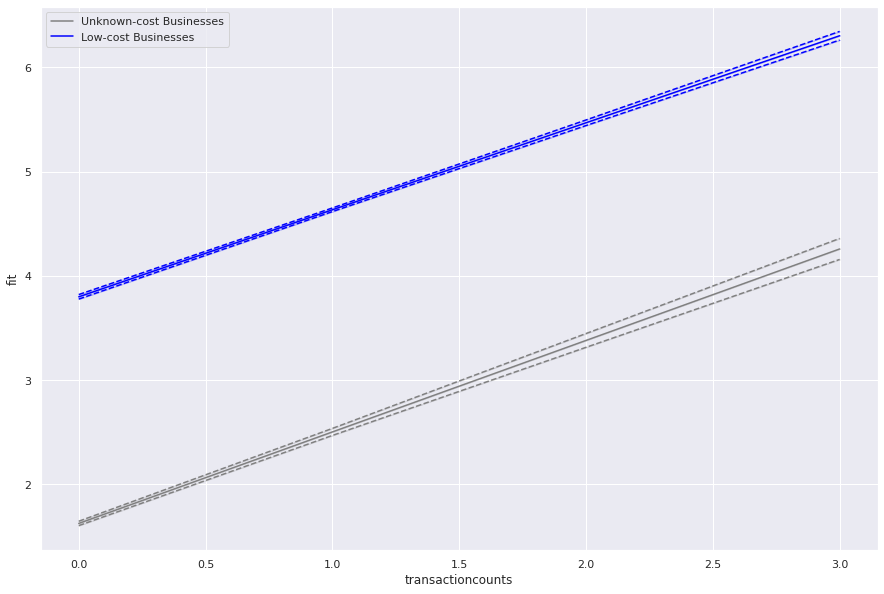

In [100]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

sns.lineplot(
    x=unknown_bus_pred_df['transactioncounts'],
    y=unknown_bus_pred_df['fit'], label= "Unknown-cost Businesses", color='grey', ax=ax)

sns.lineplot(
    x=unknown_bus_pred_df['transactioncounts'],
    y=unknown_bus_pred_df['CIlo'], color='grey', linestyle='--', ax=ax)

sns.lineplot(
    x=unknown_bus_pred_df['transactioncounts'],
    y=unknown_bus_pred_df['CIup'],  color='grey', linestyle='--', ax=ax)

sns.lineplot(
    x=low_bus_pred_df['transactioncounts'],
    y=low_bus_pred_df['fit'], label= "Low-cost Businesses", color='blue', ax=ax)

sns.lineplot(
    x=low_bus_pred_df['transactioncounts'],
    y=low_bus_pred_df['CIlo'], color='blue', linestyle='--', ax=ax)

sns.lineplot(
    x=low_bus_pred_df['transactioncounts'],
    y=low_bus_pred_df['CIup'],  color='blue', linestyle='--', ax=ax)



plt.legend()

> Note: clean up the comments,  do a y-y plot, do an F-test on the payment level variables
